In [41]:
import pandas as pd

df = pd.read_csv('data/boston.csv')

In [43]:
import numpy as np

df2 = df.copy()

# feature clipping for outlier variables
for col in ['CRIM', 'ZN', 'B']:
    # IQR
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    print(col, lower, upper)
    # feature clipping
    df2[col] = df2[col].clip(lower, upper)


# CRIM -5.31051125 9.06963875
# ZN -18.75 31.25
# B 344.10624999999993 427.49625000000003

CRIM -5.31051125 9.06963875
ZN -18.75 31.25
B 344.10624999999993 427.49625000000003


In [44]:
# Splitting the data in to train and test split for model trainin
X = df2.drop(['MEDV'], axis=1)
y = df2['MEDV']

print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [50]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [52]:
# apply min-max scaler normalization
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


categorical_cols = []
numerical_cols = ['CRIM', 'ZN', 'INDUS', 'CHAS',
                    'AGE', 'DIS', 'RAD', 'B', 'LSTAT']

# Numerical Pipeline
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ]
)

# Categorigal Pipeline
cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinalencoder', OrdinalEncoder(categories=[])),
        ('scaler', MinMaxScaler())
    ]
)

# preprocessor
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_cols),
    ('cat_pipeline', cat_pipeline, categorical_cols)
])

preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_cols),
    ('cat_pipeline', cat_pipeline, categorical_cols)
])

x_train_norm = preprocessor.fit_transform(x_train)
x_test_norm = preprocessor.transform(x_test)


In [55]:
# Model building
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train_norm, y_train)
rf_pred = rf.predict(x_test_norm)

In [56]:
# Check the training score and test score
print('Training score: ', rf.score(x_train_norm, y_train))
print('Testing score: ', rf.score(x_test_norm, y_test))
print('R2: ', r2_score(y_test, rf_pred))

Training score:  0.969449110448313
Testing score:  0.8103430386686578
R2:  0.8103430386686578


In [57]:
# As we can see that the above model is performed very well in our training data as well as for test data (since there is no much high difference between two score), 
# which ensure that there is no overfitting/underfitting the model. Perhaps hyperparameter tuning not required here. 

# Just to understand if there is any further improvement, hyper-parameter tuning is performing.

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

params = {'n_estimators':[100,300,400,600],
          'criterion':['squared_error', 'poisson', 'absolute_error', 'friedman_mse'],
          'max_depth':[2,5,8,10],
          'max_features':['auto','sqrt','log2']
          }

rf_model = RandomForestRegressor()
rf_hyp = RandomizedSearchCV(estimator=rf_model, param_distributions=params, cv=10, random_state=0, verbose=3, n_iter=10, n_jobs=-1, scoring='neg_mean_squared_error')
rf_hyp.fit(x_train_norm, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'poisson',
                                                      'absolute_error',
                                                      'friedman_mse'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 300, 400, 600]},
                   random_state=0, scoring='neg_mean_squared_error', verbose=3)

In [58]:
print(rf_hyp.best_estimator_)
print(rf_hyp.best_params_)

RandomForestRegressor(criterion='poisson', max_depth=8, max_features='auto',
                      n_estimators=400)
{'n_estimators': 400, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'poisson'}


In [59]:
rf_new_model = rf_hyp.best_estimator_
rf_new_model.fit(x_train_norm, y_train)

RandomForestRegressor(criterion='poisson', max_depth=8, max_features='auto',
                      n_estimators=400)

In [60]:
rf_pred = rf_new_model.predict(x_test_norm)

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('MAE: ', mean_absolute_error(y_test, rf_pred))
print('MSE: ', mean_squared_error(y_test, rf_pred))
print('R2: ', r2_score(y_test, rf_pred))

MAE:  3.229043760922709
MSE:  19.018088490301402
R2:  0.8075625735624319


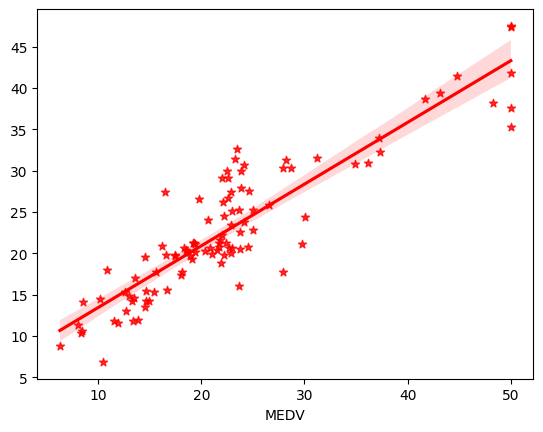

In [62]:
# plot the best-fit line
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=y_test, y=rf_pred, color='r', marker='*')
plt.show()